**Description**: Test that priors make sense and model fitting works.

**Estimated runtime**: ~1 hr 20 min

In [1]:
from typing import Literal

import arviz as az
import numpy as np
import polars as pl
import seaborn as sns
import xarray as xr

import utils

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
sns.set_theme(style="darkgrid")

# Configuration

Which number of test observations do you want to analyze?

In [3]:
num_test: Literal[200, 500] = 200

# Load data

In [4]:
accuracies_home_dir = "accuracies_from_paper"

In [5]:
num_correct_df = utils.load_all_num_correct(accuracies_home_dir, num_test)

# Simulate data

In [6]:
equation = "p(num_correct, num_test) ~ method + lm_type + (1|dataset/pair)"
id_vars = ["num_test", "pair", "lm_type", "dataset"]

In [7]:
def simulate_data(
    num_correct_df: pl.DataFrame,
    treatment_effect_prior_mean_std: tuple[float, float],
    random_seed: int = 123,
):
    # Build model to set up sampling from priors
    model = utils.create_model(
        # Picking treatment and control columns is arbitrary. Just need to tell bambi
        # what the data looks like, not what's in it. The actual data is unused
        utils.melt_num_correct(
            num_correct_df, treatment="test", control="extra", id_vars=id_vars
        ),
        equation,
        treatment_effect_prior_mean_std=treatment_effect_prior_mean_std,
    )
    model.build()

    # Fitting the model is so slow that I can only afford 1 draw
    idata_prior: az.InferenceData = model.prior_predictive(
        draws=1, random_seed=random_seed
    )
    prior: xr.DataArray = az.extract(idata_prior, group="prior_predictive")[
        "p(num_correct, num_test)"
    ]

    # Some data we'll need to populated the simulated DF
    datasets = num_correct_df["dataset"].unique(maintain_order=True)
    num_subsamples = (
        num_correct_df.group_by(["lm_type", "dataset"])
        .count()
        .select("count")
        .head(n=1)
        .item()
    )
    lm_types = num_correct_df["lm_type"].unique(maintain_order=True)

    # Inverse of melt is pivot
    # TODO: test this code for correctness
    # The number 2 in the code below refers to treatment and control
    return (
        pl.DataFrame(
            {
                "num_test": num_test,
                "pair": np.repeat(np.arange(len(num_correct_df)), 2),
                "lm_type": np.tile(
                    lm_types.to_numpy().repeat(datasets.len() * num_subsamples),
                    reps=lm_types.len(),
                ).tolist(),
                "dataset": np.tile(
                    datasets.to_numpy().repeat(num_subsamples * 2), reps=lm_types.len()
                ).tolist(),
                "method": np.tile(["control", "treatment"], reps=len(num_correct_df)),
                "num_correct": prior[:, 0].to_numpy(),
            }
        )
        .pivot(values="num_correct", index=id_vars, columns="method")
        .drop("pair")
    )

# Visually check priors

Prior predictive check = plot the distributions of the outcomes: the number of correct
predictions.

I decided to adjust some priors—$\beta$
standard deviation, $\sigma_{D}, \sigma_{V}$—from $3.5355$ to
$1$ b/c the latter results in weird, wide, basin-like outcomes. The default is also
scientifically really implausible.

This modification doesn't seem to affect the distribution of the posterior mean
($\beta$), i.e., it doesn't change the conclusions. It also didn't affect convergence
diagnostics—they're fine in both cases.

/Users/kdubey/Envs/pretrain/lib/python3.11/site-packages/formulae/terms/call.py:108: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_string_dtype(x) or is_categorical_dtype(x) or isinstance(x, CategoricalBox):
Sampling: [1|dataset:pair_offset, 1|dataset:pair_sigma, 1|dataset_offset, 1|dataset_sigma, Intercept, lm_type, method, p(num_correct, num_test)]


<Axes: ylabel='Count'>

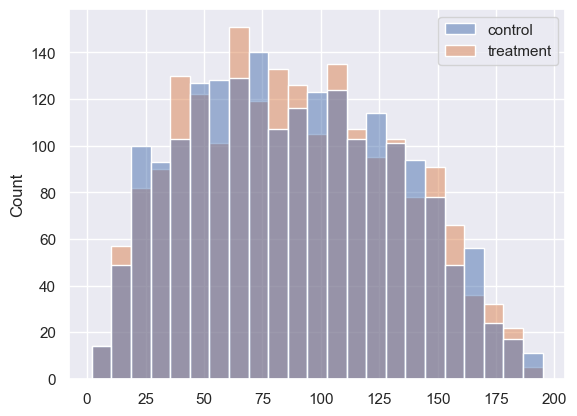

In [8]:
sns.histplot(
    simulate_data(num_correct_df, treatment_effect_prior_mean_std=(0, 0.001))
    .select(["control", "treatment"])
    .to_pandas()
)

# Test null effect

Should not see an effect outside the range of (-0.01, 0.01) if the model makes sense and
the fit code is correct.

In [9]:
num_correct_df_simluated_null = simulate_data(
    num_correct_df, treatment_effect_prior_mean_std=(0, 0.001)
)

/Users/kdubey/Envs/pretrain/lib/python3.11/site-packages/formulae/terms/call.py:108: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_string_dtype(x) or is_categorical_dtype(x) or isinstance(x, CategoricalBox):
Sampling: [1|dataset:pair_offset, 1|dataset:pair_sigma, 1|dataset_offset, 1|dataset_sigma, Intercept, lm_type, method, p(num_correct, num_test)]


/Users/kdubey/Envs/pretrain/lib/python3.11/site-packages/formulae/terms/call.py:108: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_string_dtype(x) or is_categorical_dtype(x) or isinstance(x, CategoricalBox):
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Intercept, method, lm_type, 1|dataset_sigma, 1|dataset_offset, 1|dataset:pair_sigma, 1|dataset:pair_offset]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1698 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
method[treatment],-0.001,0.005,-0.01,0.008,0.0,0.0,2026.0,1531.0,1.01


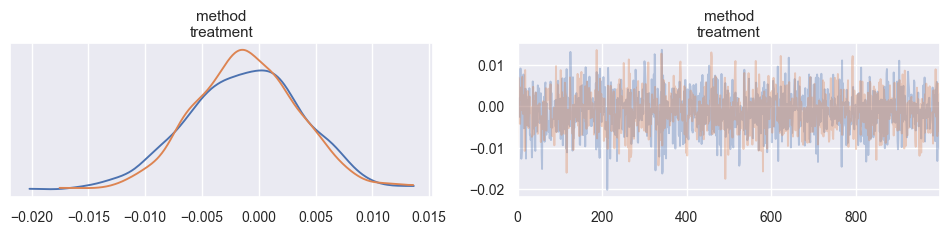

In [10]:
_ = utils.stat_model(
    num_correct_df_simluated_null,
    treatment="treatment",
    control="control",
    equation=equation,
    id_vars=id_vars,
    chains=2,
)

# Test non-null effect

Should see an effect around 0.1, not including 0, if the model makes sense and the fit
code is correct.

In [11]:
num_correct_df_simluated_non_null = simulate_data(
    num_correct_df, treatment_effect_prior_mean_std=(0.1, 0.01)
)

/Users/kdubey/Envs/pretrain/lib/python3.11/site-packages/formulae/terms/call.py:108: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_string_dtype(x) or is_categorical_dtype(x) or isinstance(x, CategoricalBox):
Sampling: [1|dataset:pair_offset, 1|dataset:pair_sigma, 1|dataset_offset, 1|dataset_sigma, Intercept, lm_type, method, p(num_correct, num_test)]


/Users/kdubey/Envs/pretrain/lib/python3.11/site-packages/formulae/terms/call.py:108: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_string_dtype(x) or is_categorical_dtype(x) or isinstance(x, CategoricalBox):
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Intercept, method, lm_type, 1|dataset_sigma, 1|dataset_offset, 1|dataset:pair_sigma, 1|dataset:pair_offset]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2019 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
method[treatment],0.111,0.005,0.102,0.12,0.0,0.0,2433.0,1719.0,1.0


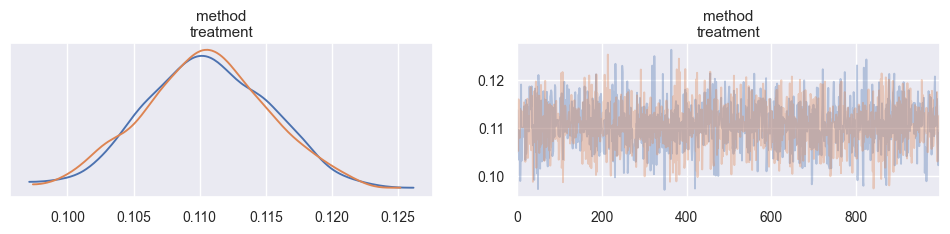

In [12]:
_ = utils.stat_model(
    num_correct_df_simluated_non_null,
    treatment="treatment",
    control="control",
    equation=equation,
    id_vars=id_vars,
    chains=2,
)